In [29]:
import sys
sys.path.insert(1, '../utilities/')


from TS_utils import TS_generator, DCT_lowpass_filter, scale_min_max, weight_ts
import numpy as np
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
LONG_HISTORY = 60
SHORT_HISTORY = 20

In [13]:
ts_generator = TS_generator(nb_timeseries=10000, chunk_size=LONG_HISTORY)

In [14]:
X = ts_generator.get_array()

In [15]:
#X = scale_relative(X)
X = scale_min_max(X)
# X = z_score(X)

# alpha = 1.05 for a 60 day history gives the 60th day(back in history) 20 times more weight that 1st day
weights_long, time_series_long = weight_ts(X, reverse=True, alpha=1.04)
# alpha = 1.2 for a 20 day history gives the 1st(back in history) day 40 times more weight that 20th day 
weights_short, time_series_short = weight_ts(X[:, (LONG_HISTORY-SHORT_HISTORY):], alpha = 1.2)

## Remove the time series with nans

# 1. get the interscection of non-nan indices
nan_indices_long = np.unique(np.argwhere(np.isnan(time_series_long))[:, 0])
nan_indices_short = np.unique(np.argwhere(np.isnan(time_series_short))[:, 0])


X = np.delete(X, nan_indices_long, 0)
time_series_long = np.delete(time_series_long, nan_indices_long, 0)
time_series_short = np.delete(time_series_short, nan_indices_short, 0)

In [16]:
X.shape

(10000, 60)

In [17]:
n_clusters = 10
clu = KMeans(n_clusters=n_clusters, random_state=0)
labels_long = clu.fit_predict(time_series_long)
# clu_medoid = KMedoids(metric="euclidean", n_clusters=n_clusters)
# labels_long = clu_medoid.fit_predict(time_series_long)


In [18]:
np.unique(labels_long)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# 1. Long vs short timescales

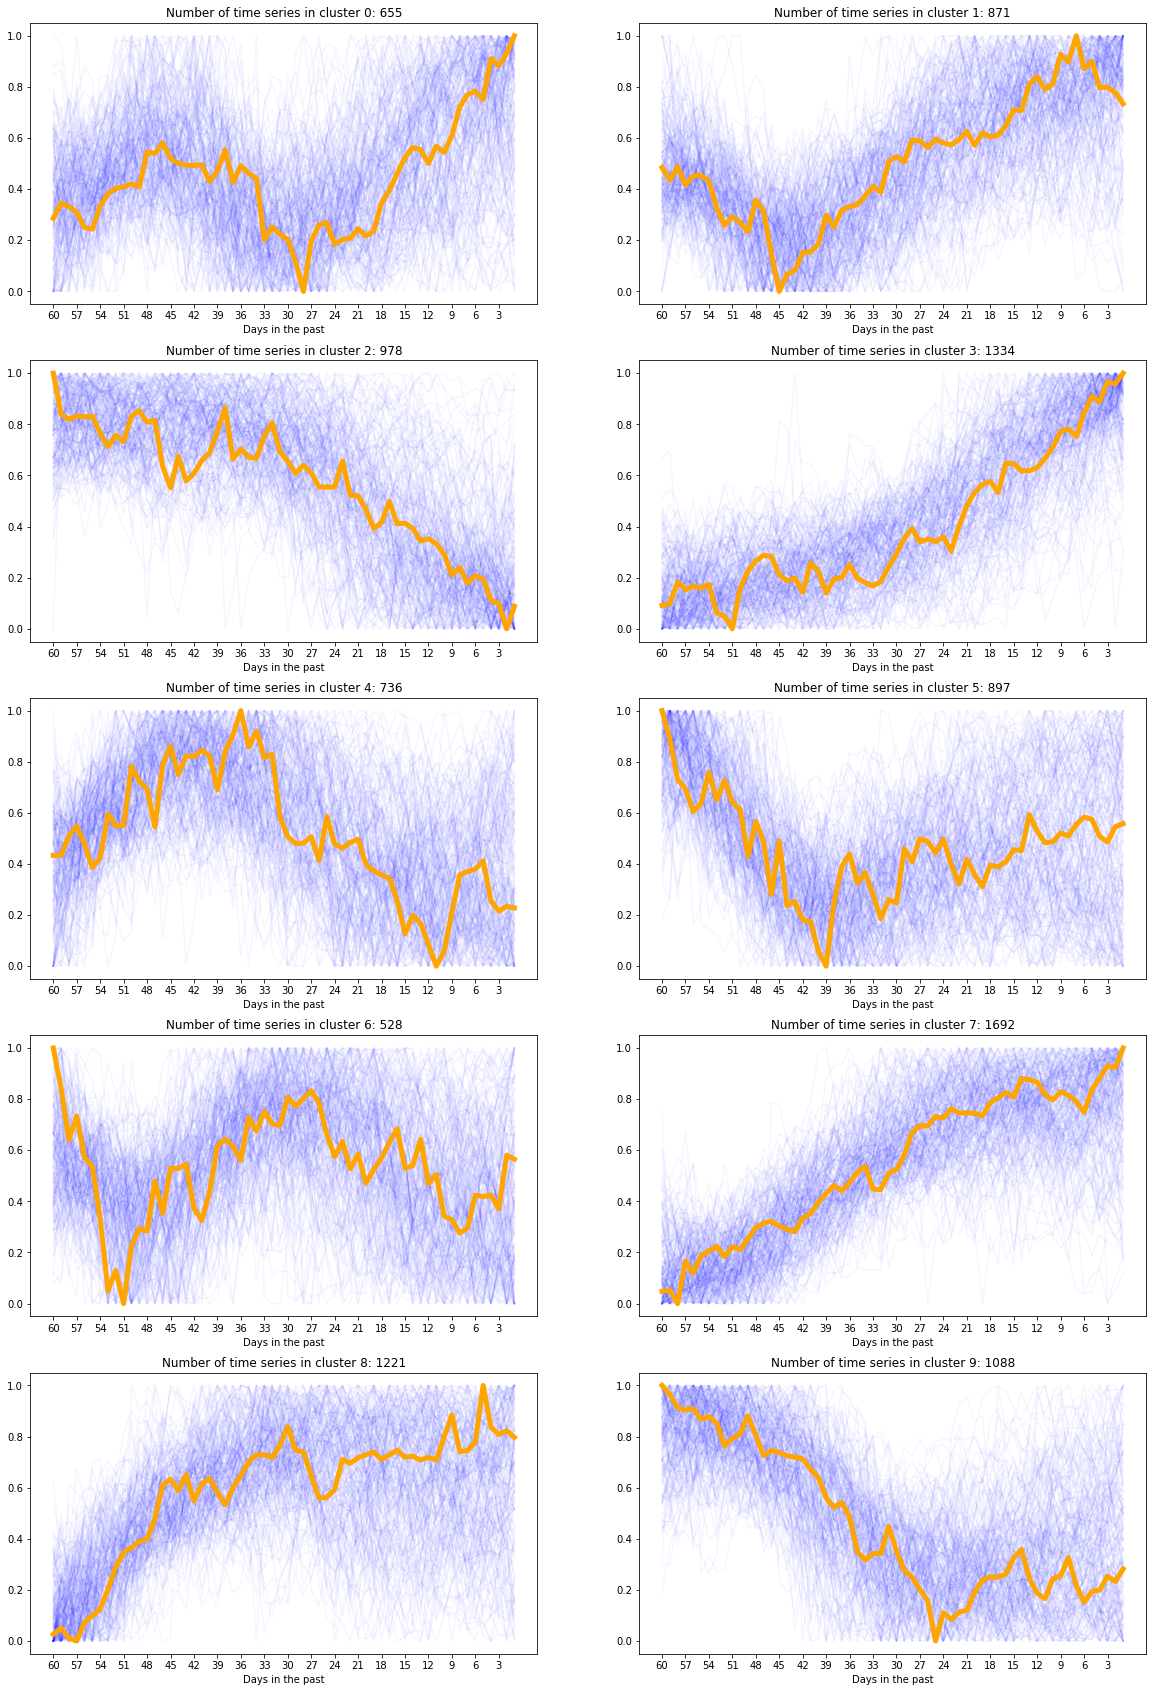

In [19]:
fig, axes = plt.subplots(n_clusters//2, 2,figsize=(20,30))
axes_list = list(axes.flatten())

for cluster_nb in range(n_clusters):
    indices1 = [i for i,x in enumerate(labels_long) if x == cluster_nb]
    if indices1:
        indices2 = np.random.choice(indices1, size=200, replace=False)
        # cluster_center = X[indices1].mean(0)
        ## Calculate the k-medoid
        temp = KMedoids(metric="euclidean", n_clusters=1)
        cluster_center = temp.fit(X[indices1]).cluster_centers_[0]
        ax = axes_list[cluster_nb]
        ax.title.set_text('Number of time series in cluster ' + str(cluster_nb) + ': ' + str(len(indices1)))
        for i in range(len(indices2)):
            ax.plot(X[indices2[i]], alpha=0.04, color='b')
            ax.set_xticks(np.arange(0, LONG_HISTORY, 3))
            ax.set_xticklabels(np.arange(LONG_HISTORY, 0, -3))
            ax.set_xlabel("Days in the past")
        ax.plot(cluster_center,color='orange',linewidth=5,alpha=1,label="center"+str(cluster_nb))
# plt.savefig(''.join([str(LONG_HISTORY)]), dpi=300)

For n_clusters = 2 The average silhouette_score is : 0.4385774062528559
For n_clusters = 4 The average silhouette_score is : 0.30071689810856445
For n_clusters = 6 The average silhouette_score is : 0.2140044068105915
For n_clusters = 8 The average silhouette_score is : 0.17556543774293512
For n_clusters = 10 The average silhouette_score is : 0.17815645147216524
For n_clusters = 2 The average silhouette_score is : 0.47690994846162793
For n_clusters = 4 The average silhouette_score is : 0.26536754499913423
For n_clusters = 6 The average silhouette_score is : 0.22529090753266706
For n_clusters = 8 The average silhouette_score is : 0.16851358111515763
For n_clusters = 10 The average silhouette_score is : 0.14283564212309968
For n_clusters = 2 The average silhouette_score is : 0.42490979214324814
For n_clusters = 4 The average silhouette_score is : 0.27153595964472826
For n_clusters = 6 The average silhouette_score is : 0.19802460431206484
For n_clusters = 8 The average silhouette_score is 

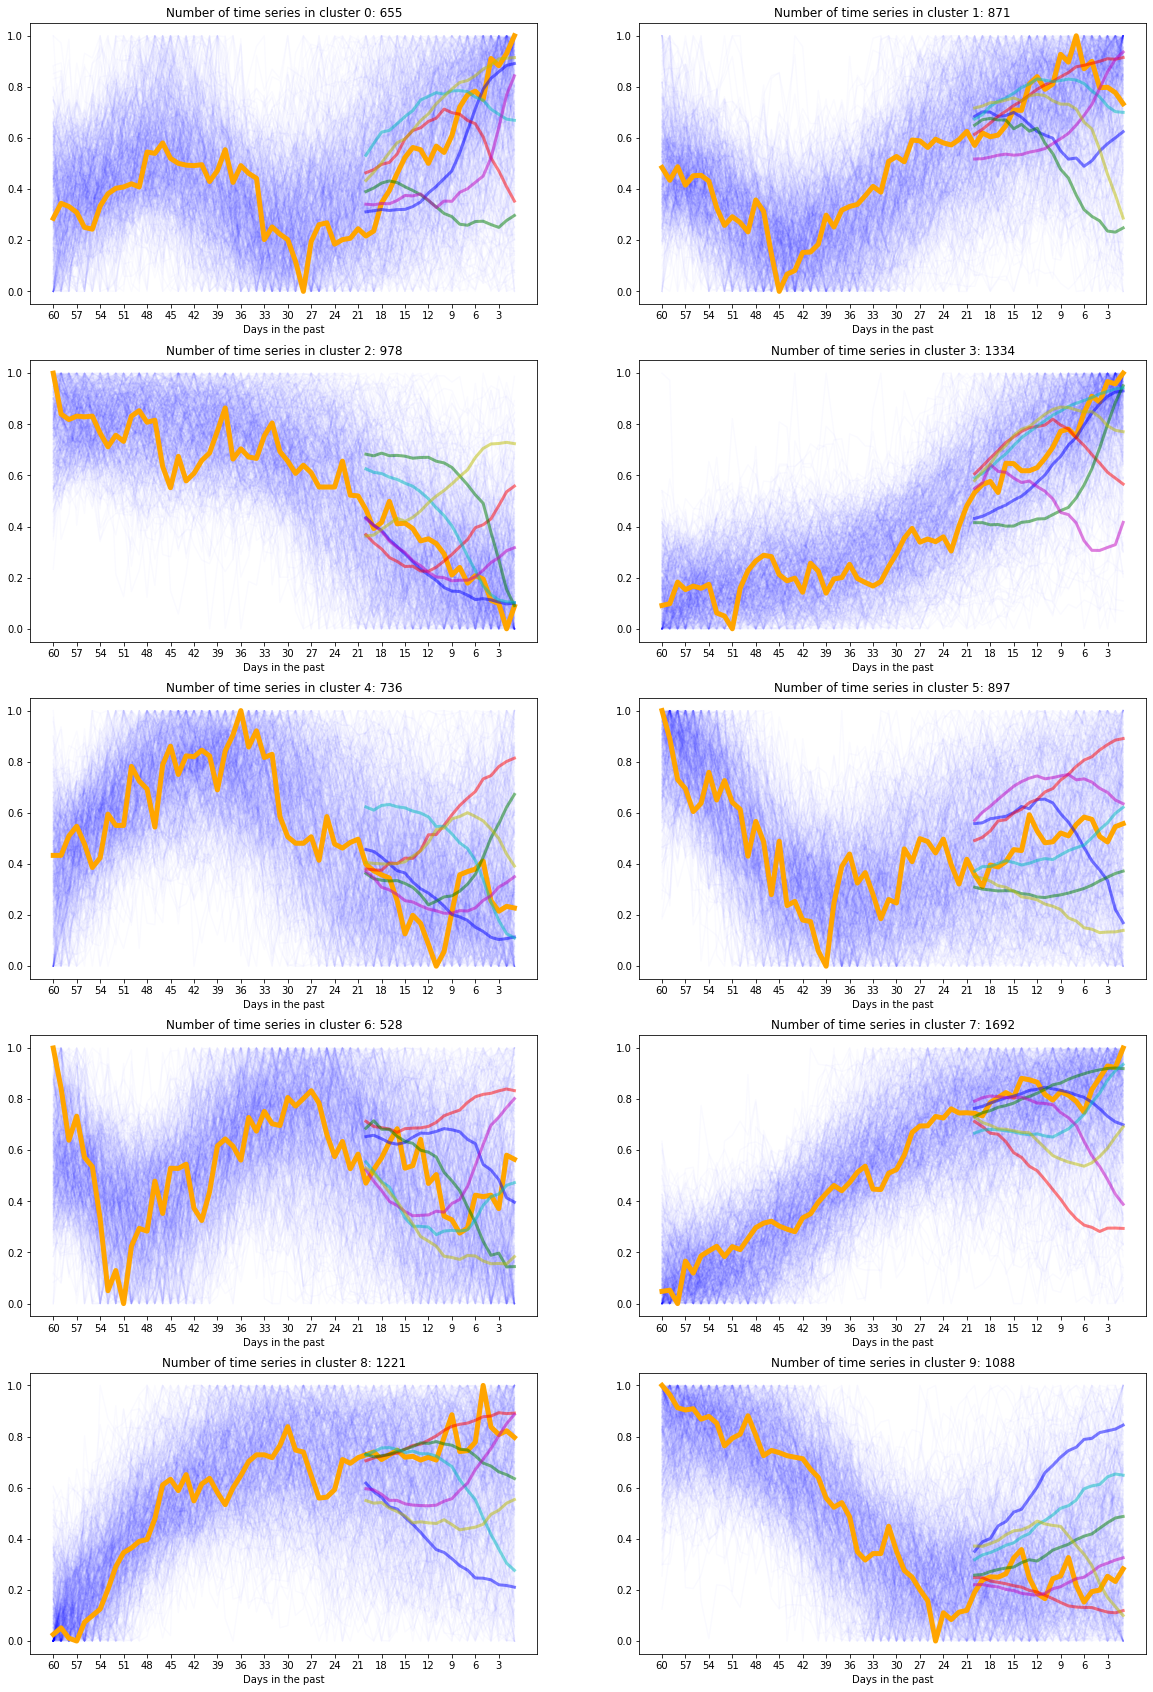

In [20]:
n_clusters = 10
fig, axes = plt.subplots(n_clusters//2, 2,figsize=(20,30))
axes_list = list(axes.flatten())
n_clusters_nested = 6
for cluster_nb in range(n_clusters):
    indices1 = [i for i,x in enumerate(labels_long) if x == cluster_nb]
    indices2 = np.random.choice(indices1, size=min(500, len(indices1)), replace=False)
    # cluster_center = X[indices1].mean(0)
    ## Calculate the k-medoid
    temp = KMedoids(metric="euclidean", n_clusters=1)
    cluster_center = temp.fit(X[indices1]).cluster_centers_[0]
    ax = axes_list[cluster_nb]
    ax.title.set_text('Number of time series in cluster ' + str(cluster_nb) + ': ' + str(len(indices1)))

    for i in range(len(indices2)):
        ax.plot(X[indices2[i]], alpha=0.02, color='b')
        ax.set_xticks(np.arange(0, LONG_HISTORY, 3))
        ax.set_xticklabels(np.arange(LONG_HISTORY, 0, -3))
        ax.set_xlabel("Days in the past")
    ax.plot(cluster_center,color='orange',linewidth=5,alpha=1,label="center_"+str(cluster_nb))
    
    X_original, X_cluster = X[:, (LONG_HISTORY-SHORT_HISTORY):][indices1], time_series_short[indices1]

    for n_cluster_trial in range(2,12,2):
        clusterer = KMeans(n_clusters=n_cluster_trial, random_state=10)
        cluster_labels = clusterer.fit_predict(X_cluster)
        silhouette_avg = silhouette_score(X_cluster, cluster_labels)
        print("For n_clusters =", n_cluster_trial,
            "The average silhouette_score is :", silhouette_avg)

    clu = KMeans(n_clusters=n_clusters_nested, random_state=0)
    labels = clu.fit_predict(X_cluster)
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'b', 'r', 'g', 'c']

    for cluster_nb_nested in range(n_clusters_nested):
        indices1_ = [i for i,x in enumerate(labels) if x == cluster_nb_nested]
        nested_cluster_center_mean = X_original[indices1_].mean(0)
        temp = KMedoids(metric="euclidean", n_clusters=1)
        nested_cluster_center_medoid = temp.fit(X_original[indices1_]).cluster_centers_[0]
        ax.plot(np.arange(40,60), nested_cluster_center_mean, color=colors[cluster_nb_nested], linewidth=3, alpha=0.5, label="nested_center_"+str(cluster_nb_nested))
plt.savefig(''.join(['nested_clustering_multiscale', str(LONG_HISTORY)]), dpi=300)

# 2. Course vs fine grained

## Silhoutte Score Analysis

For n_clusters = 4 The average silhouette_score is : 0.20042956837969175
For n_clusters = 6 The average silhouette_score is : 0.1482065113464167
For n_clusters = 8 The average silhouette_score is : 0.11768823497785506
For n_clusters = 10 The average silhouette_score is : 0.11309141669067642
For n_clusters = 12 The average silhouette_score is : 0.10679406452306239


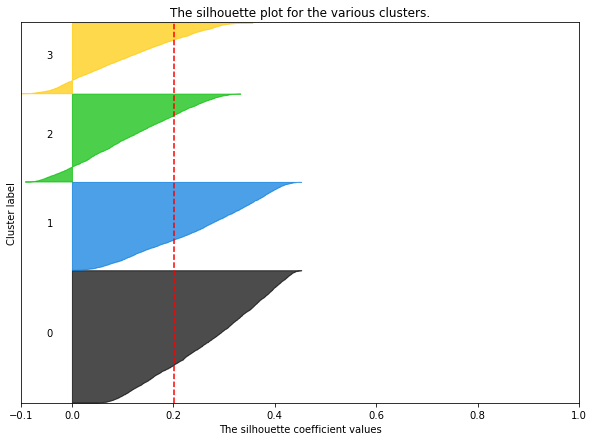

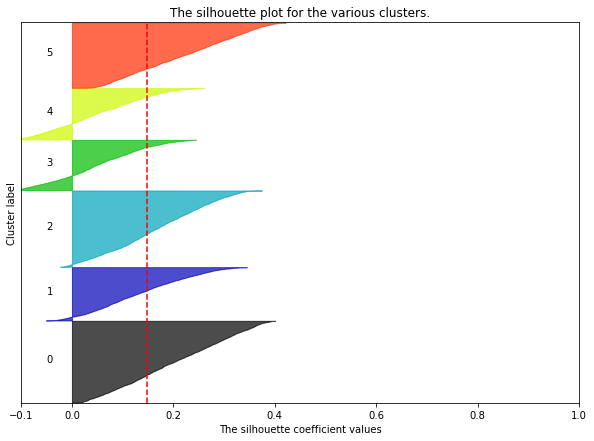

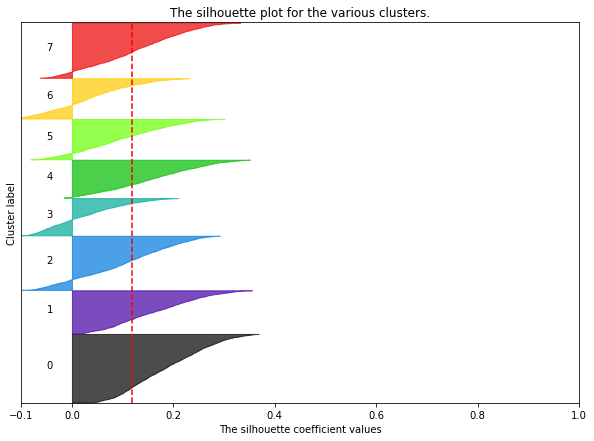

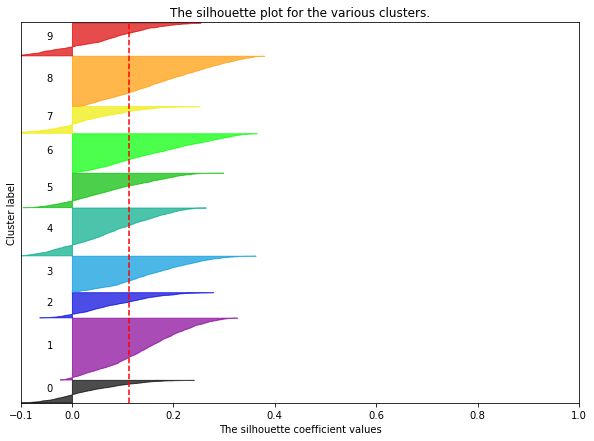

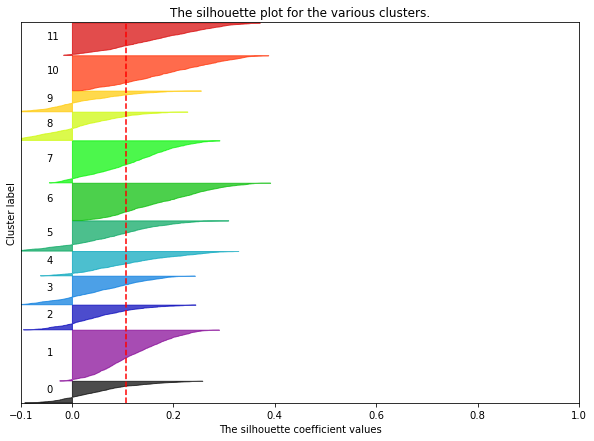

In [21]:
for n_clusters in range(4,14,2):
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(time_series_long)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(time_series_long, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(time_series_long, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# plt.show()

In [22]:
time_series_course = X[:, 0:-1:3]

For n_clusters = 4 The average silhouette_score is : 0.16197780359198938
For n_clusters = 6 The average silhouette_score is : 0.14420570309319058
For n_clusters = 8 The average silhouette_score is : 0.12064155043942655
For n_clusters = 10 The average silhouette_score is : 0.12463093990237378
For n_clusters = 12 The average silhouette_score is : 0.11011956308460308


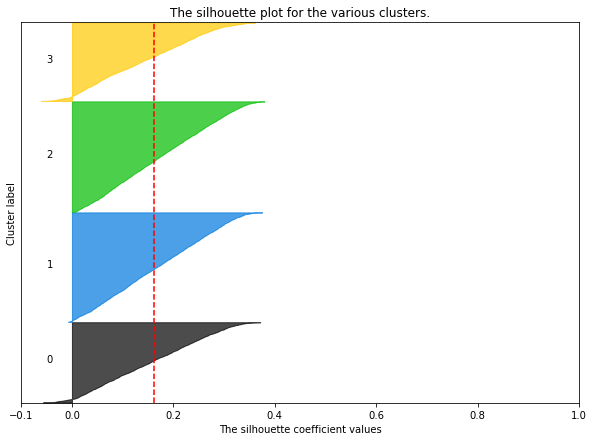

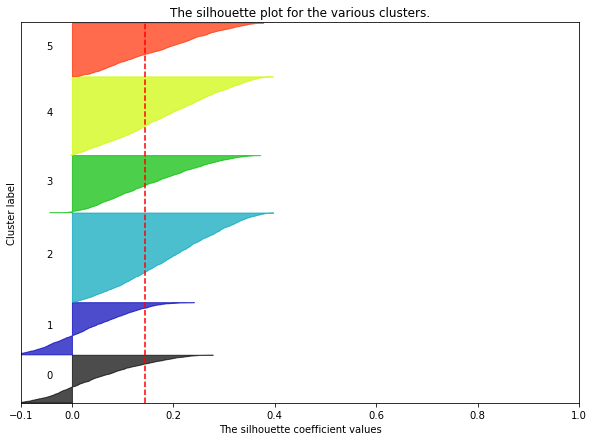

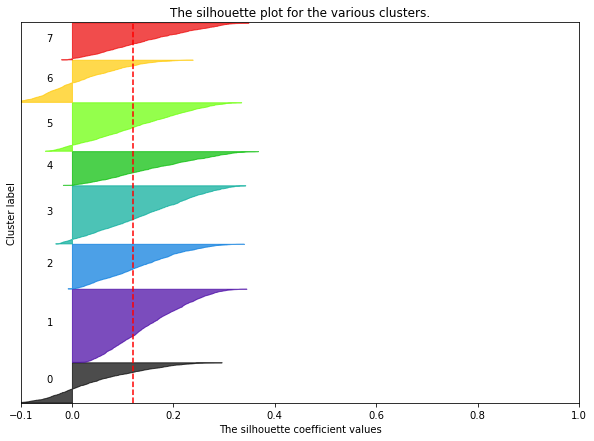

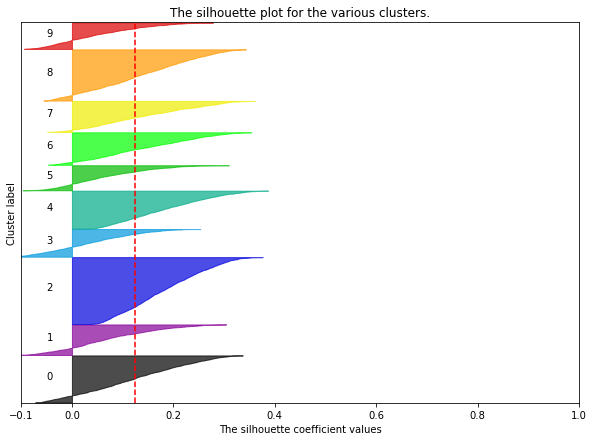

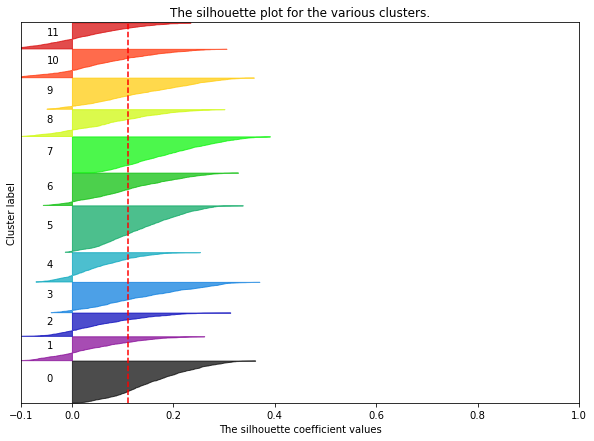

In [23]:
for n_clusters in range(4,14,2):
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(time_series_course)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(time_series_course, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(time_series_course, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

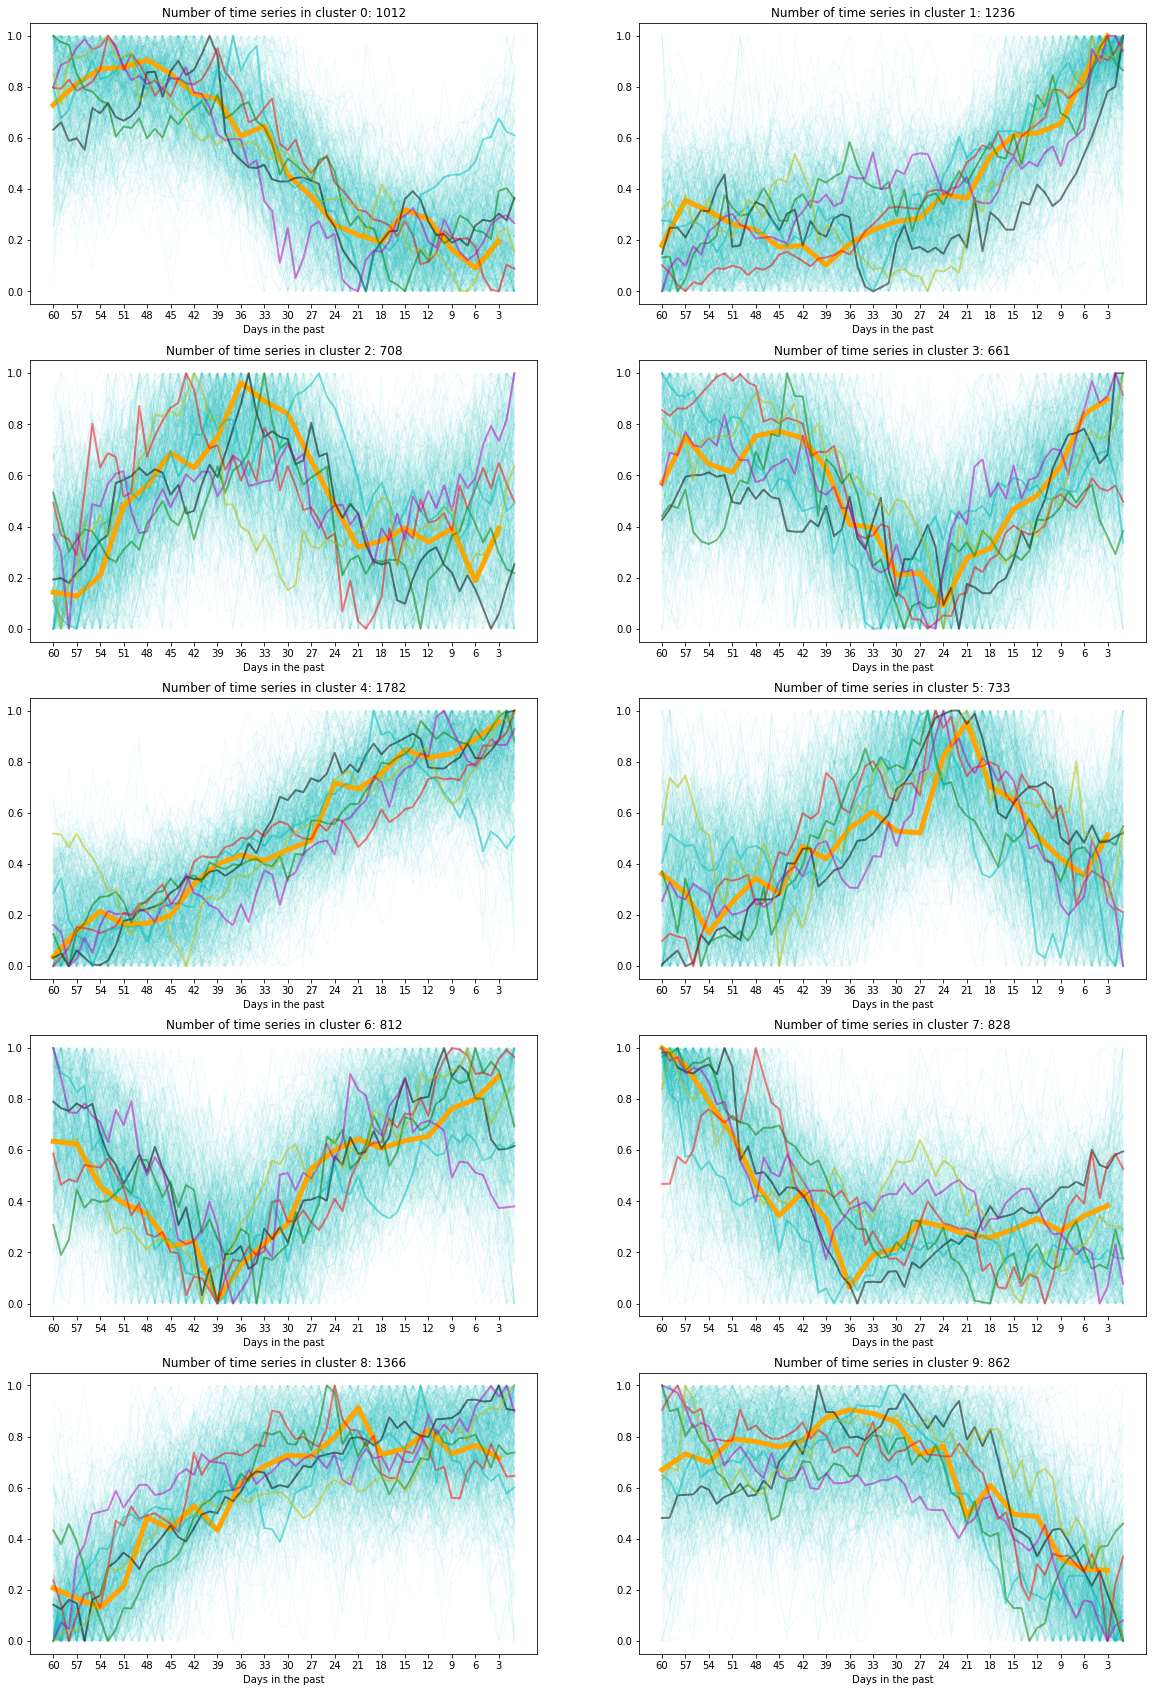

In [24]:
n_clusters = 10
clu = KMeans(n_clusters=n_clusters, random_state=0)
labels_course = clu.fit_predict(time_series_course)

fig, axes = plt.subplots(n_clusters//2, 2,figsize=(20,30))
axes_list = list(axes.flatten())

n_clusters_nested = 6

for cluster_nb in range(n_clusters):
    indices1 = [i for i,x in enumerate(labels_course) if x == cluster_nb]
    indices2 = np.random.choice(indices1, size=min(500, len(indices1)), replace=False)
    temp = KMedoids(metric="euclidean", n_clusters=1)
    cluster_center = temp.fit(time_series_course[indices1]).cluster_centers_[0]
    ax = axes_list[cluster_nb]
    for i in range(len(indices2)):
        ax.plot(X[indices2[i]], linewidth=1, alpha=0.05, color='c')
    ax.title.set_text('Number of time series in cluster ' + str(cluster_nb) + ': ' + str(len(indices1)))
    ax.set_xticks(np.arange(0, LONG_HISTORY, 3))
    ax.set_xticklabels(np.arange(LONG_HISTORY, 0, -3))
    ax.set_xlabel("Days in the past")
    course_center = ax.plot(np.arange(0, LONG_HISTORY, 3), cluster_center,color='orange',linewidth=5,alpha=1,label="center_"+str(cluster_nb))
    
    clu = KMeans(n_clusters=n_clusters_nested, random_state=0)
    X_cluster = X[indices1]
    labels = clu.fit_predict(X_cluster)
    colors = ['k', 'r', 'g', 'c', 'm', 'y']
    for cluster_nb_nested in range(n_clusters_nested):
        indices1_ = [i for i,x in enumerate(labels) if x == cluster_nb_nested]
        temp = KMedoids(metric="euclidean", n_clusters=1)
        nested_cluster_center_medoid = temp.fit(X_cluster[indices1_]).cluster_centers_[0]
        ax.plot(nested_cluster_center_medoid, color=colors[cluster_nb_nested], linewidth=2, alpha=0.5, label="nested_center_"+str(cluster_nb_nested))
plt.savefig(''.join(['nested_clustering_course', str(LONG_HISTORY)]), dpi=300)

## Independent clustering for short and long timescales, conditional distribution of the two sets of clusters

### Longer timescale clusters

In [25]:
print(time_series_long.shape)
n_clusters = 10
clu = KMeans(n_clusters=n_clusters, random_state=0)
labels_long = clu.fit_predict(time_series_long)

(10000, 60)


### Shorter timescale clusters

In [26]:
clu = KMeans(n_clusters=n_clusters, random_state=0)
labels_short = clu.fit_predict(time_series_short)

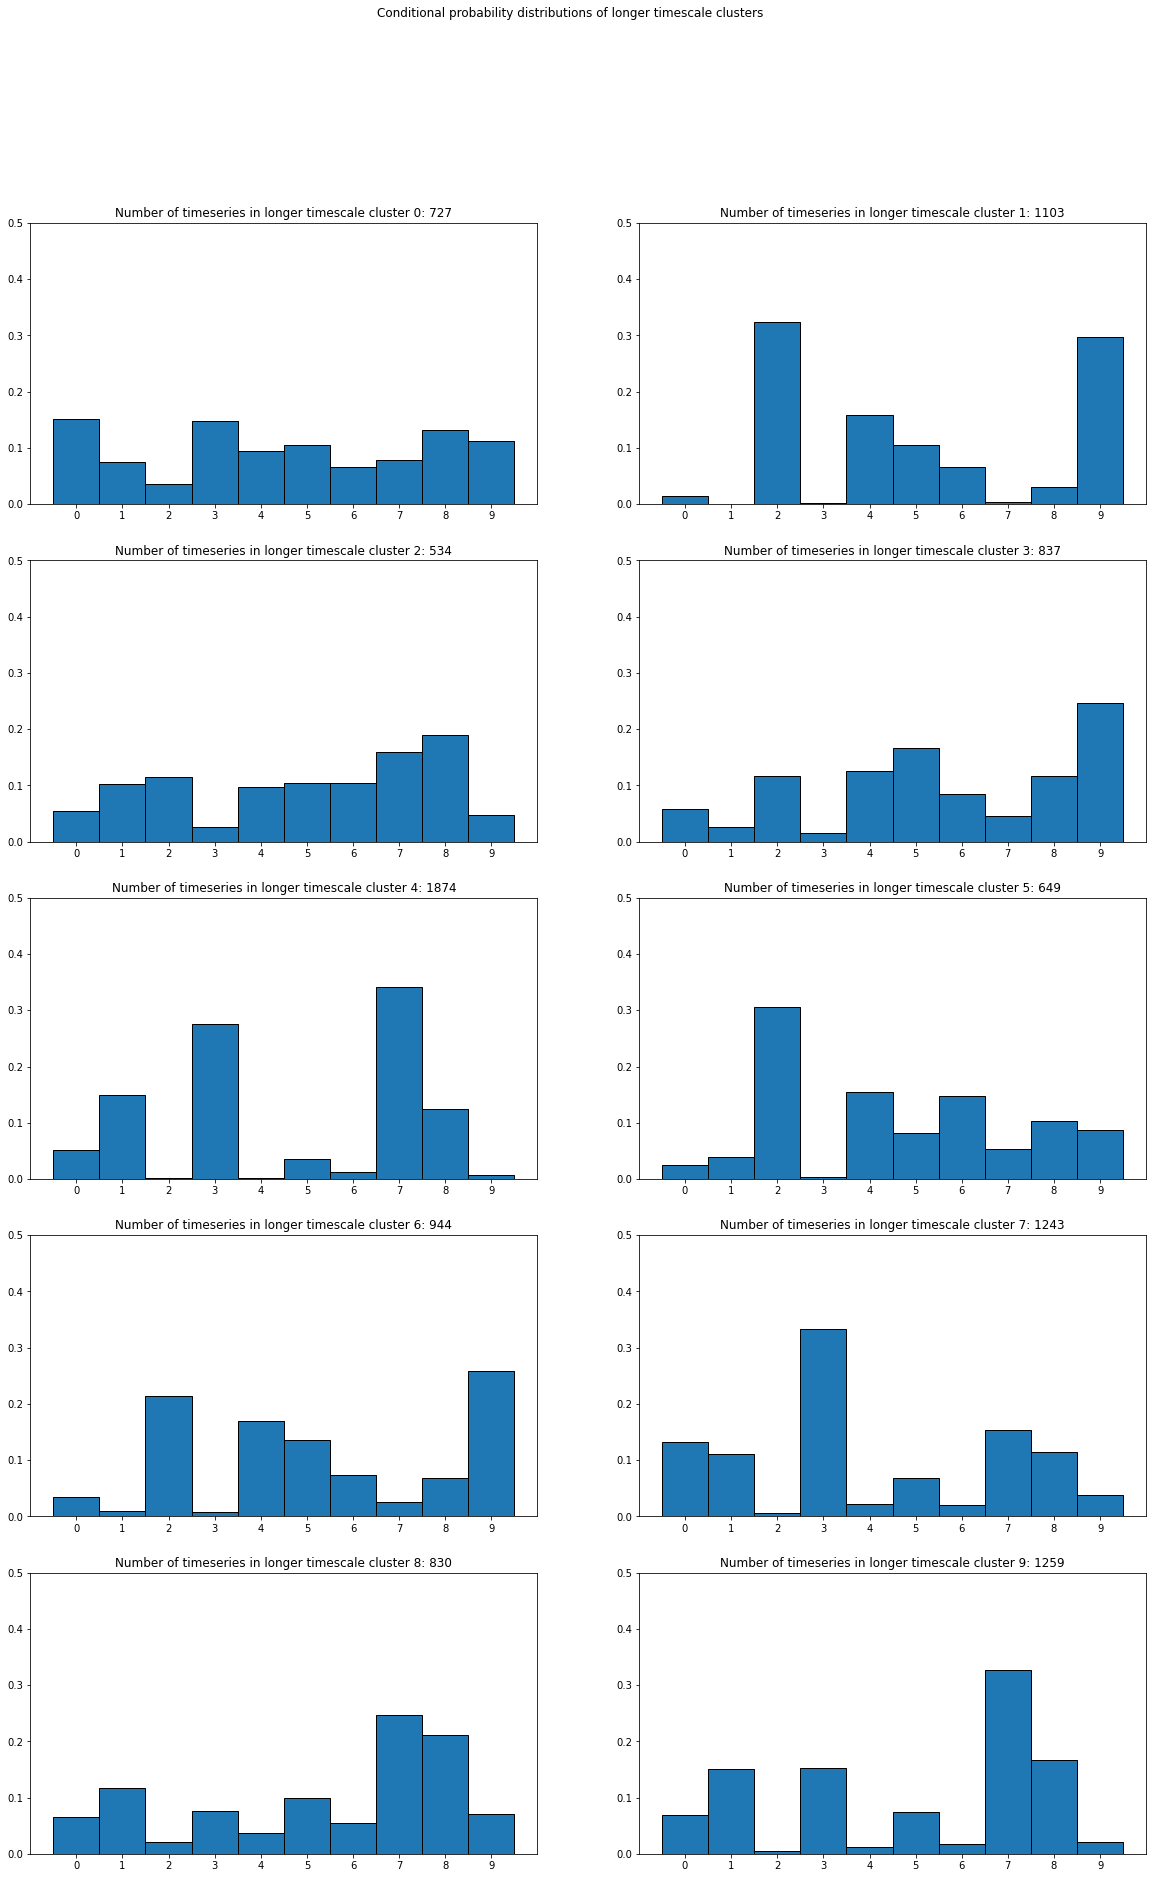

In [27]:
fig, axes = plt.subplots(n_clusters//2, 2,figsize=(20,30))
axes_list = list(axes.flatten())
fig.suptitle("Conditional probability distributions of longer timescale clusters")
for short_timescale_cluster in range(n_clusters):
    time_series_ids = [i for i,x in enumerate(labels_short) if x == short_timescale_cluster]
    conditional_labels = labels_long[time_series_ids]
    ax = axes_list[short_timescale_cluster]
    d = np.diff(np.unique(conditional_labels)).min()
    left_of_first_bin = conditional_labels.min() - float(d)/2
    right_of_last_bin = conditional_labels.max() + float(d)/2
    ax.hist(conditional_labels, np.arange(left_of_first_bin, right_of_last_bin + d, d), density=True, edgecolor='black')
    ax.title.set_text('Number of timeseries in longer timescale cluster ' + str(short_timescale_cluster) + ': ' + str(len(time_series_ids)))
    ax.set_xticks(range(10))
    ax.set_ylim([0, 0.5])

plt.show()

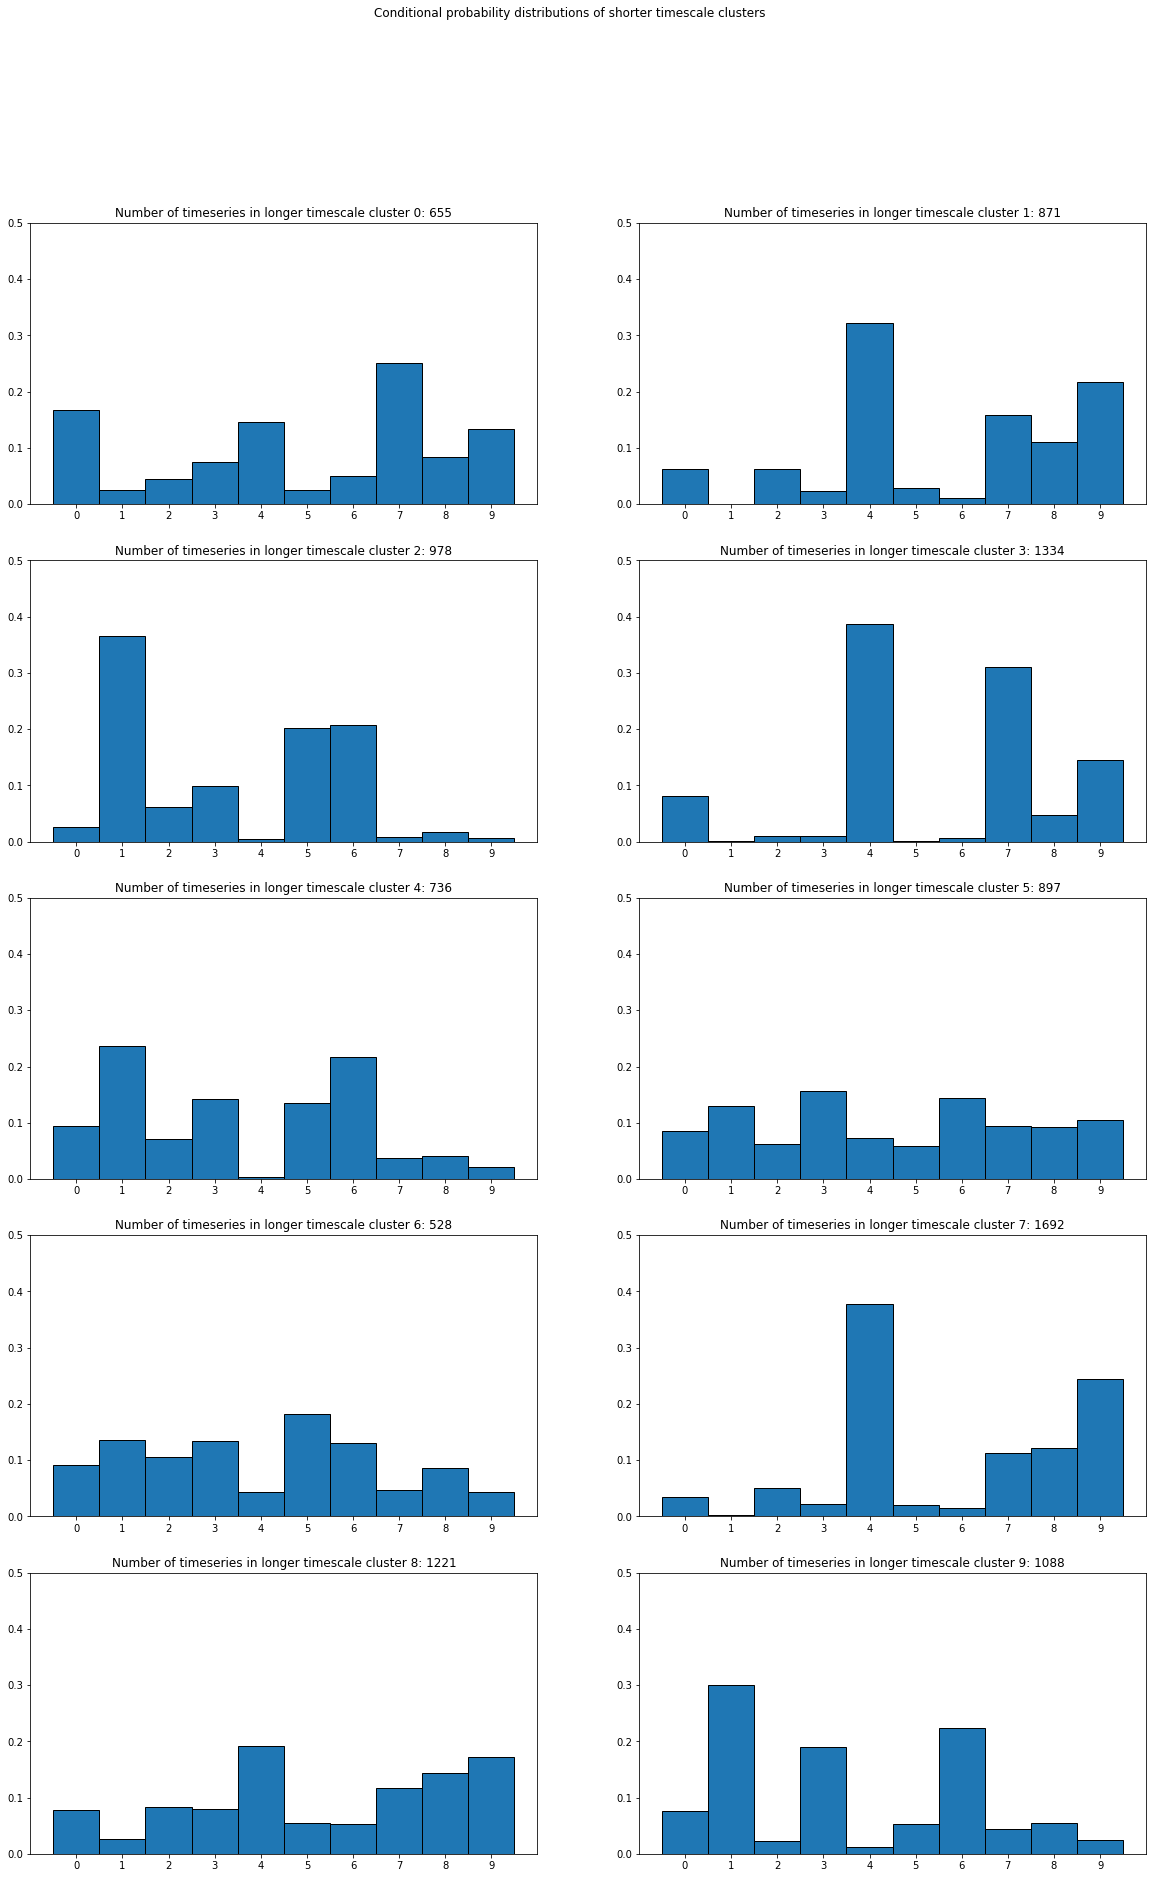

In [28]:
fig, axes = plt.subplots(n_clusters//2, 2,figsize=(20,30))
axes_list = list(axes.flatten())
fig.suptitle("Conditional probability distributions of shorter timescale clusters")
for long_timescale_cluster in range(n_clusters):
    time_series_ids = [i for i,x in enumerate(labels_long) if x == long_timescale_cluster]
    conditional_labels = labels_short[time_series_ids]
    ax = axes_list[long_timescale_cluster]
    d = np.diff(np.unique(conditional_labels)).min()
    left_of_first_bin = conditional_labels.min() - float(d)/2
    right_of_last_bin = conditional_labels.max() + float(d)/2
    ax.hist(conditional_labels, np.arange(left_of_first_bin, right_of_last_bin + d, d), density=True, edgecolor='black')
    ax.title.set_text('Number of timeseries in longer timescale cluster ' + str(long_timescale_cluster) + ': ' + str(len(time_series_ids)))
    ax.set_xticks(range(10))
    ax.set_ylim([0, 0.5])

plt.show()